## **Load Data**:

In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [172]:
df=pd.read_csv("clinical_trial_with_target.csv")

In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130000 entries, 0 to 129999
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   nct_id             130000 non-null  object 
 1   phase              129555 non-null  object 
 2   condition          130000 non-null  object 
 3   intervention_type  129877 non-null  object 
 4   study_design       129037 non-null  object 
 5   sponsor_type       130000 non-null  object 
 6   enrollment         126269 non-null  float64
 7   status             130000 non-null  object 
 8   gender             130000 non-null  object 
 9   min_age            129704 non-null  object 
 10  max_age            100348 non-null  object 
 11  location           122897 non-null  object 
 12  start_date         129349 non-null  object 
 13  completion_date    129104 non-null  object 
 14  results            130000 non-null  object 
 15  p_value            118732 non-null  float64
 16  fi

In [174]:
df=df[df['p_value'].notna()]

In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118732 entries, 0 to 129999
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   nct_id             118732 non-null  object 
 1   phase              118732 non-null  object 
 2   condition          118732 non-null  object 
 3   intervention_type  118732 non-null  object 
 4   study_design       118716 non-null  object 
 5   sponsor_type       118732 non-null  object 
 6   enrollment         118732 non-null  float64
 7   status             118732 non-null  object 
 8   gender             118732 non-null  object 
 9   min_age            118732 non-null  object 
 10  max_age            95719 non-null   object 
 11  location           118732 non-null  object 
 12  start_date         118732 non-null  object 
 13  completion_date    118732 non-null  object 
 14  results            118732 non-null  object 
 15  p_value            118732 non-null  float64
 16  final_s

## **EDA**:

In [176]:
df['completion_date'] = pd.to_datetime(df['completion_date'])
df['start_date'] = pd.to_datetime(df['start_date'])
df['duration'] = (df['completion_date'] - df['start_date']).dt.days
df.drop(['completion_date', 'start_date'], axis=1, inplace=True)

df['duration'].describe()

count    118732.000000
mean       5562.816705
std        1491.153510
min        1795.000000
25%        4841.000000
50%        4841.000000
75%        4841.000000
max        8596.000000
Name: duration, dtype: float64

/tmp/ipykernel_7716/1043625701.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='final_status', data=df, palette='viridis')


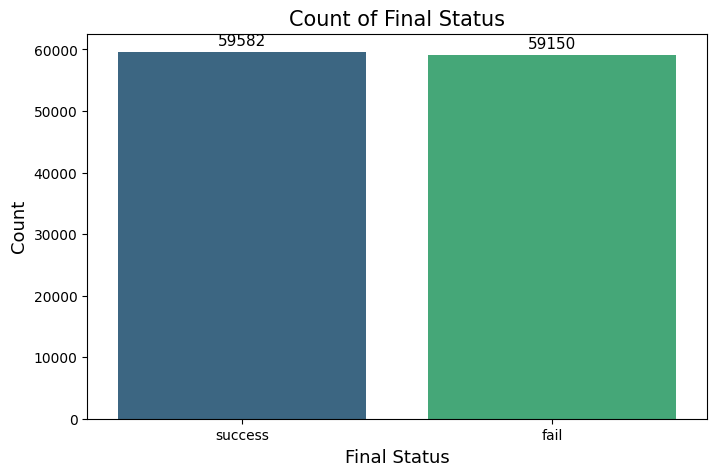

'Total successful and failed trials'

In [177]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='final_status', data=df, palette='viridis')
plt.title('Count of Final Status', fontsize=15)
plt.xlabel('Final Status', fontsize=13)
plt.ylabel('Count', fontsize=13)

# Annotate values on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 8), textcoords='offset points', fontsize=11)

plt.show()

'''Total successful and failed trials'''

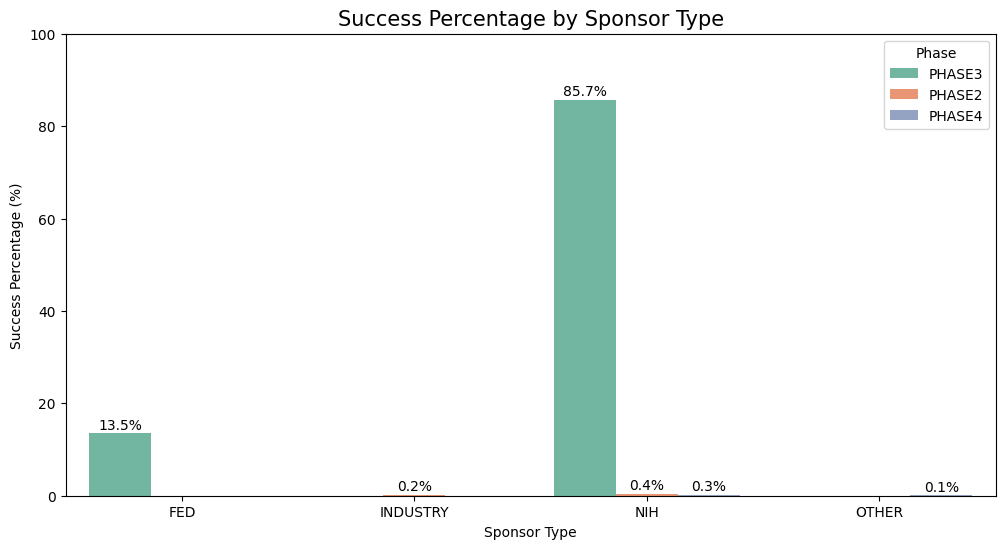

Number of successful trials for each sponsor:


sponsor_type
NIH         51422
FED          8025
INDUSTRY       98
OTHER          37
Name: count, dtype: int64

In [178]:
# Calculate percentage of successful trials for each sponsor_type and phase relative to total successful trials
success_df= df[df['final_status']=='success']
total_success = success_df.shape[0]
success_pct = (
    success_df.groupby(['sponsor_type', 'phase'])
    .size()
    .reset_index(name='count')
)
success_pct['success_percentage'] = (success_pct['count'] / total_success) * 100

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=success_pct,
    x='sponsor_type',
    y='success_percentage',
    hue='phase',
    palette='Set2'
)
plt.title('Success Percentage by Sponsor Type', fontsize=15)
plt.xlabel('Sponsor Type')
plt.ylabel('Success Percentage (%)')
plt.ylim(0, 100)
plt.legend(title='Phase')

ax.tick_params(colors='black')
for spine in ax.spines.values():
    spine.set_color('black')

# Annotate bars with percentage values
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height) and height > 0:
        ax.annotate(f'{height:.1f}%', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='center', xytext=(0, 6), textcoords='offset points', fontsize=10, color='black')

plt.show()

print('Number of successful trials for each sponsor:')

success_df['sponsor_type'].value_counts()

/tmp/ipykernel_7716/1786715144.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=success_phase_percentage.index, y=success_phase_percentage.values, palette='viridis')


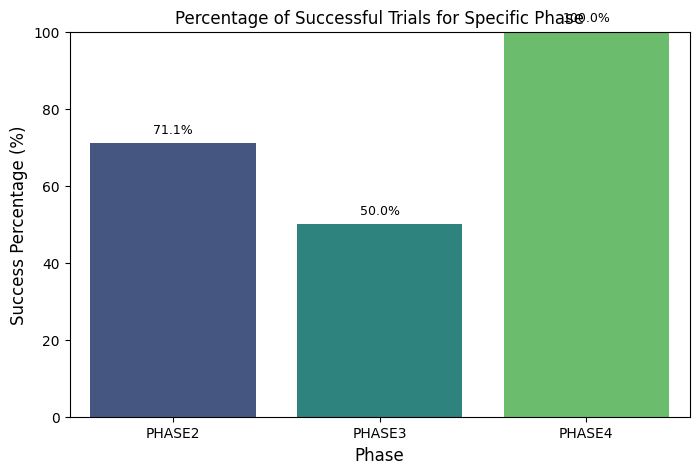

Number of successful trials for each phase:


phase
PHASE3    59071
PHASE2      325
PHASE4      186
Name: count, dtype: int64

In [179]:
phase_percentage = df.groupby('phase')['final_status'].value_counts(normalize=True).unstack() * 100
success_phase_percentage = phase_percentage['success'].dropna()

plt.figure(figsize=(8, 5))
ax = sns.barplot(x=success_phase_percentage.index, y=success_phase_percentage.values, palette='viridis')
plt.title('Percentage of Successful Trials for Specific Phase', fontsize=12)
plt.xlabel('Phase', fontsize=12)
plt.ylabel('Success Percentage (%)', fontsize=12)
plt.ylim(0, 100)

# Annotate bars with percentage values
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=9, xytext=(0, 5), textcoords='offset points')

plt.show()
print('Number of successful trials for each phase:')
success_df['phase'].value_counts()

In [180]:
df['phase'].value_counts()

phase
PHASE3    118089
PHASE2       457
PHASE4       186
Name: count, dtype: int64

/tmp/ipykernel_7716/4088039542.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=gender_percentage.index, y=gender_percentage.values, palette='viridis')


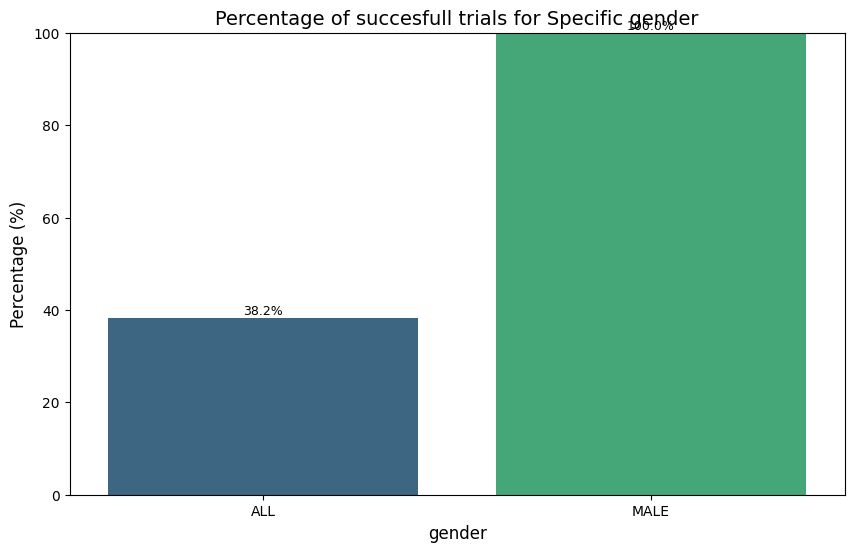

Number of Successful trials on females = 0 
Number of successful tirals for each gender:


gender
ALL     36585
MALE    22997
Name: count, dtype: int64

In [181]:
gender_percentage = df.groupby('gender')['final_status'].value_counts(normalize=True).unstack() * 100
gender_percentage = gender_percentage['success']  # Select the percentage for output_label == 1

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=gender_percentage.index, y=gender_percentage.values, palette='viridis')
plt.title('Percentage of succesfull trials for Specific gender', fontsize=14)
plt.xlabel('gender', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.ylim(0, 100)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=9)

plt.show()
print("Number of Successful trials on females = 0 \nNumber of successful tirals for each gender:" )
success_df['gender'].value_counts()

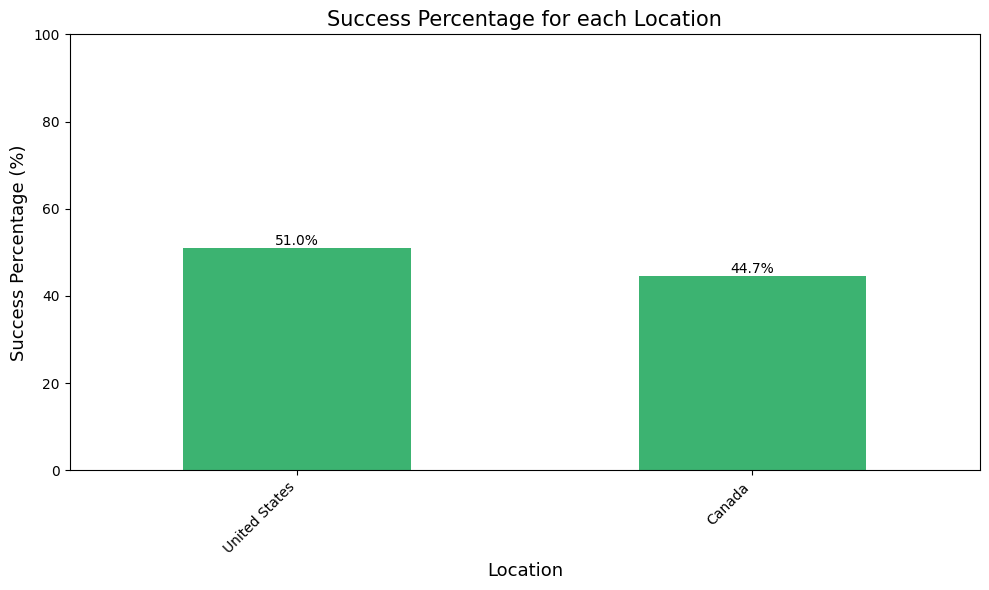

Total number of trials conducted in each location:


location
United States    103503
Canada            15229
Name: count, dtype: int64

In [182]:
# Calculate percentage of successful trials for each location
location_total = df['location'].value_counts()
location_success_count = success_df['location'].value_counts()
location_success_pct = (location_success_count / location_total) * 100

# Plot the percentage of successful trials for each location
plt.figure(figsize=(10, 6))
ax = location_success_pct.plot(kind='bar', color='mediumseagreen')
plt.title('Success Percentage for each Location', fontsize=15)
plt.xlabel('Location', fontsize=13)
plt.ylabel('Success Percentage (%)', fontsize=13)
plt.ylim(0, 100)
plt.xticks(rotation=45, ha='right')

# Annotate bars with percentage values
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

print("Total number of trials conducted in each location:")
df['location'].value_counts()


In [183]:
df['study_design'].value_counts()

study_design
RANDOMIZED    118716
Name: count, dtype: int64

In [184]:
df['intervention_type'].value_counts()

intervention_type
DRUG    118732
Name: count, dtype: int64

In [185]:
df['status'].value_counts()

status
COMPLETED    118732
Name: count, dtype: int64

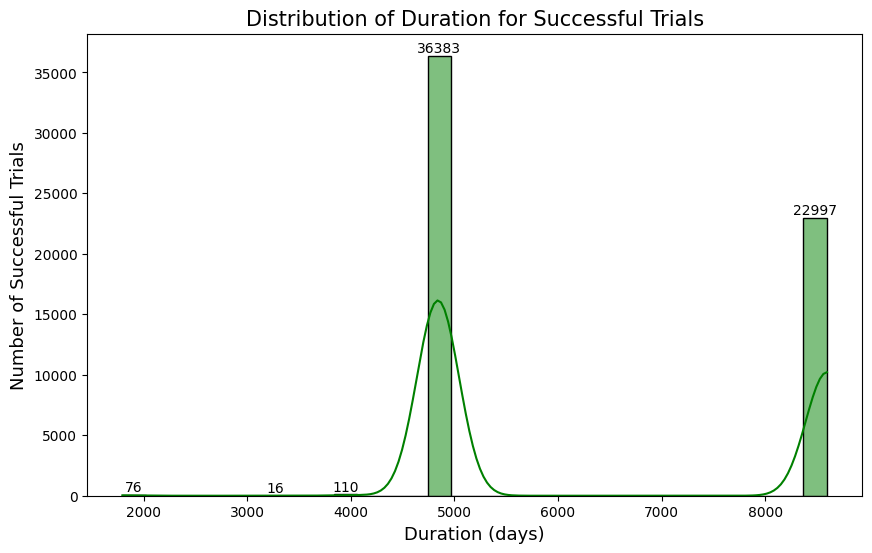

In [186]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(success_df['duration'].dropna(), bins=30, kde=True, color='green')
plt.title('Distribution of Duration for Successful Trials', fontsize=15)
plt.xlabel('Duration (days)', fontsize=13)
plt.ylabel('Number of Successful Trials', fontsize=13)

# Annotate values on top of each bar
for p in ax.patches:
    height = int(p.get_height())
    if height > 0:
        ax.annotate(f'{height}', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='bottom', fontsize=10, color='black')

plt.show()

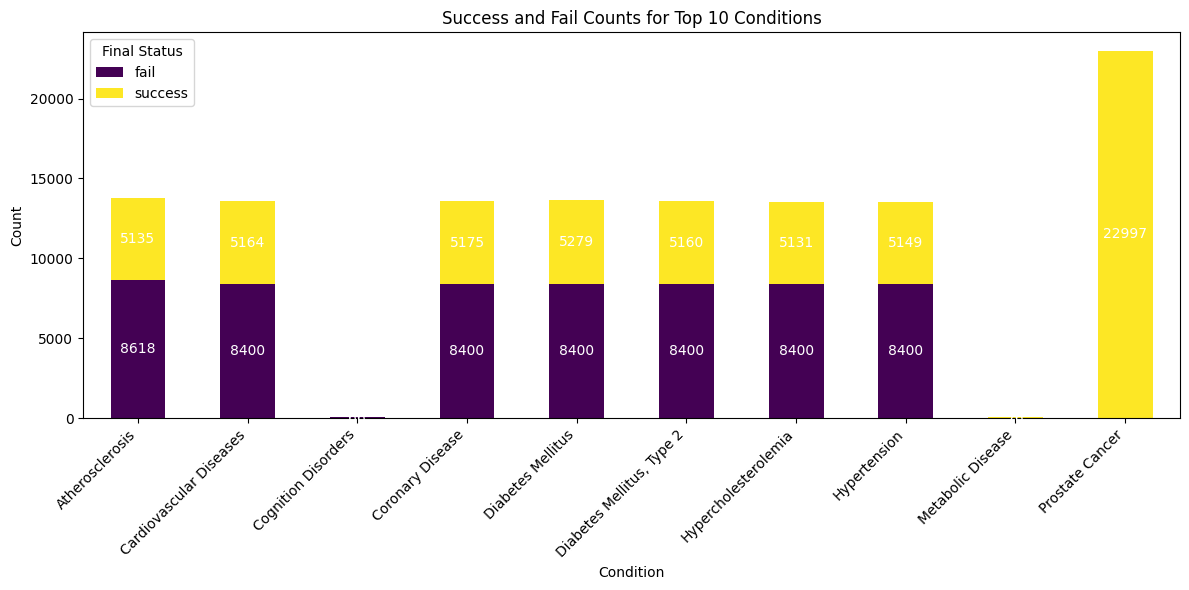

In [187]:
# Get top 10 most frequent conditions
top_conditions = df['condition'].value_counts().nlargest(10).index

# Filter dataframe for top conditions
df_top_conditions = df[df['condition'].isin(top_conditions)]

# Create a crosstab for condition vs final_status
condition_status_counts = pd.crosstab(df_top_conditions['condition'], df_top_conditions['final_status'])

# Plot stacked bar chart
ax = condition_status_counts.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.title('Success and Fail Counts for Top 10 Conditions')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Final Status')
plt.tight_layout()

# Annotate values on each bar segment
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.annotate(f'{int(height)}',
                        (bar.get_x() + bar.get_width() / 2., bar.get_y() + height / 2),
                        ha='center', va='center', fontsize=10, color='white')

plt.show()

In [188]:
df['condition'].value_counts()

condition
Prostate Cancer              22997
Atherosclerosis              13753
Diabetes Mellitus            13679
Coronary Disease             13575
Cardiovascular Diseases      13564
Diabetes Mellitus, Type 2    13560
Hypertension                 13549
Hypercholesterolemia         13531
Metabolic Disease               76
Cognition Disorders             66
HIV Infections                  66
Obesity                         58
Sleep Apnea Syndrome            56
Depression                      41
Schizophrenia                   40
Psychotic Disorder              37
Melancholia                     35
Childhood Schizophrenia         33
Focal Glomerulosclerosis         5
Proteinuria                      3
Kidney Failure                   3
Fibrosis                         3
Nephrotic Syndrome               2
Name: count, dtype: int64

/tmp/ipykernel_7716/2884174289.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='phase', y='duration', data=df, estimator=np.mean, ci=None, palette='viridis')
/tmp/ipykernel_7716/2884174289.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='phase', y='duration', data=df, estimator=np.mean, ci=None, palette='viridis')


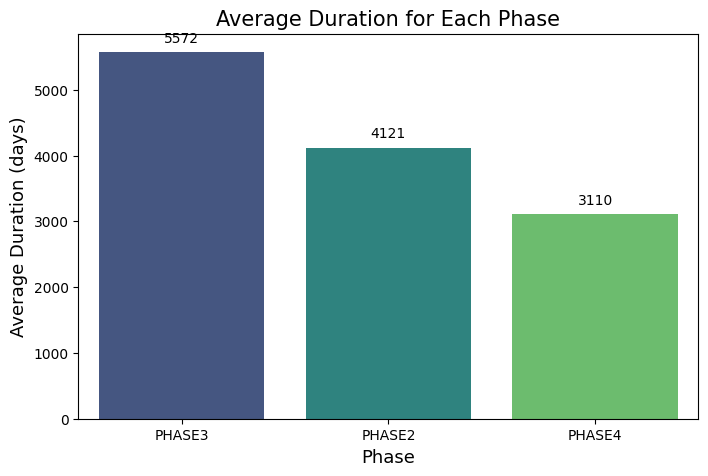

In [189]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='phase', y='duration', data=df, estimator=np.mean, ci=None, palette='viridis')
plt.title('Average Duration for Each Phase', fontsize=15)
plt.xlabel('Phase', fontsize=13)
plt.ylabel('Average Duration (days)', fontsize=13)

# Annotate bars with average duration values
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, xytext=(0, 5), textcoords='offset points')

plt.show()

In [190]:
success_df['gender'].value_counts()

gender
ALL     36585
MALE    22997
Name: count, dtype: int64

In [191]:
df.drop(['nct_id', 'intervention_type', 'study_design', 'status', 'results', 'p_value', 'min_age', 'max_age'], axis=1, inplace=True)

In [192]:
len(df['sponsor_type'].value_counts())

4

In [193]:
'''

phase- label
condition- ohe-hot
sponsor_type- one-hot
enrollment- normalize
gender- onehot
duration- normalize

'''

'\n\nphase- label\ncondition- ohe-hot\nsponsor_type- one-hot\nenrollment- normalize\ngender- onehot\nduration- normalize\n\n'

In [194]:
# Label encoding Phase Column
label_encoder = LabelEncoder()
label_encoder.fit(df['phase'])
df['phase_encoded'] = label_encoder.transform(df['phase'])
print(df[['phase', 'phase_encoded']])
df=df.drop(['phase'], axis=1) # Dropping the original phase column after encoding

         phase  phase_encoded
0       PHASE3              1
2       PHASE3              1
3       PHASE3              1
4       PHASE3              1
5       PHASE3              1
...        ...            ...
129995  PHASE3              1
129996  PHASE3              1
129997  PHASE3              1
129998  PHASE3              1
129999  PHASE3              1

[118732 rows x 2 columns]


In [195]:
# Print the mapping of classes to encoded values in label_encoder
for idx, class_label in enumerate(label_encoder.classes_):
    print(f"{class_label} -> {idx}")

PHASE2 -> 0
PHASE3 -> 1
PHASE4 -> 2


In [197]:
# One-hot encoding categorical variables
df=pd.get_dummies(df, drop_first= True, dtype=int,
                  columns=['sponsor_type', 'gender', 'condition', 'final_status', 'location'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118732 entries, 0 to 129999
Data columns (total 31 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   enrollment                           118732 non-null  float64
 1   duration                             118732 non-null  int64  
 2   phase_encoded                        118732 non-null  int64  
 3   sponsor_type_INDUSTRY                118732 non-null  int64  
 4   sponsor_type_NIH                     118732 non-null  int64  
 5   sponsor_type_OTHER                   118732 non-null  int64  
 6   gender_MALE                          118732 non-null  int64  
 7   condition_Cardiovascular Diseases    118732 non-null  int64  
 8   condition_Childhood Schizophrenia    118732 non-null  int64  
 9   condition_Cognition Disorders        118732 non-null  int64  
 10  condition_Coronary Disease           118732 non-null  int64  
 11  condition_Depressi

In [203]:
df['duration'].describe()

count    118732.000000
mean       5562.816705
std        1491.153510
min        1795.000000
25%        4841.000000
50%        4841.000000
75%        4841.000000
max        8596.000000
Name: duration, dtype: float64

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
df[['enrollment', 'duration']] = scaler.fit_transform(df[['enrollment', 'duration']])

In [211]:
df['duration'].describe()

count    118732.000000
mean          0.484068
std           1.000004
min          -2.042723
25%           0.000000
50%           0.000000
75%           0.000000
max           2.518195
Name: duration, dtype: float64

In [212]:
df.to_csv("ProcessedData.csv")